<a href="https://colab.research.google.com/github/Sopralapanca/TwitterDataset-DM-Project/blob/develop/DM_understanding_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What will be done here...

Following the suggestion given from the milestone description, the scope of this notebook is to get a first knowledge of the dataset, seeing the dimension of it and get hints on how to handle it correcty. To achive these scopes we will read the content of the columns and convert them in the right type, in the end we will propose some plots that contain first informations on how the data are distributed. 

A deeper analysis will be done after the cleaning and substitution of wrong rows in the next notebook **Data Preparation**.

Task 1.1: Data Understanding

Explore the dataset with the analytical tools studied and write a concise “data understanding”
report assessing data quality, the distribution of the variables and the pairwise correlations.
Subtasks of DU:

1. Data semantics for each feature that is not described above and the new one defined
by the team
2. Distribution of the variables and statistics
3. Assessing data quality (missing values, outliers, duplicated records, errors)
4. Variables transformations
5. Pairwise correlations and eventual elimination of redundant variables

# Import libraries and load the data

In [ ]:
!pip install calmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import pandas as pd
from pandas import DataFrame

import numpy as np

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
import calendar
import calmap
import os

from os import path
from sys import getsizeof

In [ ]:
# download data from google drive

if not path.exists('users.csv'):
  users_fileid = "16b7Gbe69-SaVzGc1x3s3s7b8lzHgd5BR"
  tweets_fileid = "1qYoicySRBbLi9Y8ZytMEi9ee2dIhxxUe"

  !gdown $users_fileid
  !gdown $tweets_fileid

Downloading...
From: https://drive.google.com/uc?id=16b7Gbe69-SaVzGc1x3s3s7b8lzHgd5BR
To: /content/users.csv
100% 641k/641k [00:00<00:00, 81.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qYoicySRBbLi9Y8ZytMEi9ee2dIhxxUe
To: /content/tweets.csv
100% 1.86G/1.86G [00:20<00:00, 91.1MB/s]


In [ ]:
tweet_path = "tweets.csv"
user_path = "users.csv"

# max_rows is used to load a portion of the dataset

max_rows = 0
 
users_df = pd.read_csv(user_path) 

if max_rows != 0:
  tweets_df = pd.read_csv(tweet_path, nrows=max_rows, encoding="UTF-8")
else:
  tweets_df = pd.read_csv(tweet_path, encoding="UTF-8")

# **Data Understanding**

---



## Data Semantics

From the project specifications we have:

USERS CSV

1. User Id: an incremental identifier for the user
2. Statues Count: the count of the tweets made by the user at the moment of data
crawling (it is involving only the tweets)
3. Lang: the user’s language selected, there are listed also slangs derived from the country
4. Created at: the timestamp in which the profile was created, many dates are wrong
5. Label: a binary variable that indicates if a user is a bot or a genuine user

TWEETS CSV

1. ID: an incremental identifier for the tweet, reply or comment
2. User Id: a unique identifier for the user who wrote the tweet
3. Retweet count: number of retweets for the tweet in analysis
4. Reply count: number of reply for the tweet in analysis
5. Favorite count: number of likes received 
6. Num hashtags: number of hashtags used in the tweet
7. Num urls: number of urls in the tweet
8. Num mentions: number of mentions in the tweet
9. Created at: when the tweet was created, many are wrong
10. Text: the text of the tweet

#### Tweet.csv informations

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   user_id         object
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: object(10)
memory usage: 1.0+ GB


In [ ]:
tweets_df.head(2)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
0,509354017856950272,327746321,0,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang..."
1,583002592529121280,333722906,1,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit..."


#### User.csv informations

In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


In [ ]:
users_df.head(2)

,id,name,lang,bot,created_at,statuses_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0


## Assessing data quality

**Checking if there are any missing values and count them**

In [ ]:
def nan_unique_count(df: DataFrame):
  print('| {:>15} | {:>15}| {:>15} |'.format(*["column", "unique values", "NaN" ]))
  print('------------------------------------------------------')
  for col in df.columns:
    print('| {:>15} | {:>15}| {:>15} |'.format(*[col, len(df[col].unique()), df[col].isna().sum() ]))

In [ ]:
nan_unique_count(tweets_df)

|          column |   unique values|             NaN |
------------------------------------------------------
|              id |        11672136|               2 |
|         user_id |          222286|          217283 |
|   retweet_count |          229168|          437134 |
|     reply_count |          158620|          647878 |
|  favorite_count |          158764|          647542 |
|    num_hashtags |          104780|         1057524 |
|        num_urls |          157146|          648623 |
|    num_mentions |          131539|          854165 |
|      created_at |         8127084|               0 |
|            text |         6778479|          537721 |


In [ ]:
nan_unique_count(users_df)

|          column |   unique values|             NaN |
------------------------------------------------------
|              id |           11508|               0 |
|            name |           11361|               1 |
|            lang |              26|               0 |
|             bot |               2|               0 |
|      created_at |           11423|               0 |
|  statuses_count |            3837|             399 |


As shown above there are some null values inside the two dataframes. In addition, the info method of pandas gives us information about the type of attributes in the dataframe. As you can see all the features in the tweets dataframe are of type "object" this means that non-numeric values are present in attributes that should be numbers such as id, user_id and so on. The data is therefore to be cleaned and properly transformed to the right type.

**Anomalies on numeric fields**

In [ ]:
# to check if non-numeric values are present in the dataset  
# we throw an exception when we try to convert the feature to the correct type.

tweets_cols = ["id", "user_id", "retweet_count", "reply_count",
           "favorite_count", "num_hashtags",  "num_urls", "num_mentions"]

user_cols = ["id", "statuses_count"]

# checking non-numeric values inside tweets df
for col in tweets_cols:
    try:
        pd.to_numeric(tweets_df[col], errors='raise')
    except Exception as e:
      print(f"column: {col} error: {e}")

# checking non-numeric values inside users df
for col in user_cols:
    try:
        pd.to_numeric(users_df[col], errors='raise')
    except Exception as e:
      print(f"column: {col} error: {e}")

column: id error: Unable to parse string "iylbzyeiw" at position 32
column: user_id error: Unable to parse string "nviem1q" at position 84
column: retweet_count error: Unable to parse string "04fzba6h4f" at position 75
column: reply_count error: Unable to parse string "0ngi" at position 105
column: favorite_count error: Unable to parse string "ai6" at position 42
column: num_hashtags error: Unable to parse string "2wtmdqfavz" at position 49
column: num_urls error: Unable to parse string "626z3" at position 273
column: num_mentions error: Unable to parse string "qdrybz8m1f" at position 202


In [ ]:
# count non-numeric values on tweets dataframe

for col in tweets_cols:
  mask = pd.to_numeric(tweets_df[col], errors='coerce').isna()
  a = mask.sum()

  print(f"column {col} has {a} non-numeric values")

del mask

column id has 433862 non-numeric values
column user_id has 433895 non-numeric values
column retweet_count has 625456 non-numeric values
column reply_count has 809504 non-numeric values
column favorite_count has 808097 non-numeric values
column num_hashtags has 1163677 non-numeric values
column num_urls has 808953 non-numeric values
column num_mentions has 987990 non-numeric values


**Anomalies on datetime**

In [ ]:
# checking correct datetime in tweets df and user df

try:
  pd.to_datetime(tweets_df["created_at"], errors='raise')
except Exception as e:
  print(e)

try:
  pd.to_datetime(users_df["created_at"], errors='raise')
except Exception as e:
  print(e)

no error in datetime format has been found

**Anomalies on languages**

In [ ]:
print(users_df["lang"].unique())

['en' 'it' 'fr' 'ru' 'es' 'tr' 'en-gb' 'pt' 'nl' 'id' 'zh-tw' 'ja' 'de'
 'ko' 'en-AU' 'da' 'ar' 'en-GB' 'Select Language...' 'zh-TW' 'zh-cn' 'pl'
 'el' 'fil' 'sv' 'xx-lc']


We can immediately notice erroneous values such as "Select Language..." or the repetition of "zh-tw/zh-TW". These values will be cleaned in the data cleaning section.

In [ ]:
users_df.loc[users_df['lang'] == 'Select Language...']

,id,name,lang,bot,created_at,statuses_count
4166,2956613720,Leanne Arker,Select Language...,0,2020-01-05 00:09:59,57.0
8666,2904858613,Brooke,Select Language...,0,2019-11-22 05:44:46,85.0


In [ ]:
tweets_df.loc[tweets_df['user_id'] == '2956613720'].head(2)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
205040,586696968333725696,2956613720,0,0,0,0,0,1,2020-04-12 01:07:12,@bernardchickey I've heard of something called...
581709,560136340663070720,2956613720,13933,0,0,0,0,2,2020-01-29 18:04:45,RT @stephenfry: If physical diseases were trea...


In [ ]:
tweets_df.loc[tweets_df['user_id'] == '2904858613'].head(2)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
51778,577066752946794496,2904858613,0,0,0,0,0,1,2020-03-16 11:20:09,@GinnyBlackmore fucking sad
471354,577046340795957248,2904858613,0,0,0,0,0,1,2020-03-16 09:59:03,@NataliaKills had the right to an opinion mean...


In [ ]:
users_df.loc[users_df['lang'] == 'xx-lc']

,id,name,lang,bot,created_at,statuses_count
10065,29552151,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0


In [ ]:
tweets_df.loc[tweets_df['user_id'] == '29552151'].head(2)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
6119,491274532679081984,29552151,0,0,0,0,0,0,2019-07-23 17:32:30,"Spent the majority of my day drawing around, c..."
12218,488693001456463872,29552151,0,0,0,0,0,0,2019-07-16 14:34:25,We all love dem cuddles. http://t.co/fPrcnUfacS


We can state that the erroneous languages are from users that writes english tweets

**Anomalies on user id**

In [ ]:
# check if there are duplicated ids on users dataframe
users_df[users_df['id'].duplicated() & users_df['id'].notnull()]["id"]

Series([], Name: id, dtype: int64)

No duplicated ids found

**Anomalies on bot label**

In [ ]:
# check if the column is binary
print(users_df['bot'].isin([0,1]).all())

True


## Assigning correct type to attribute

In [ ]:
tweets_ssize = getsizeof(tweets_df)/(1024.0**3)
user_ssize = getsizeof(users_df)/(1024.0**2)
print("Tweets Dataframe specifics : ------------- \n{} - size: {:.2f} GB\n".format(tweets_df.dtypes, tweets_ssize))
print("Users Dataframe specifics:------------- \n{} - size: {:.2f} MB".format(users_df.dtypes, user_ssize))

Tweets Dataframe specifics : ------------- 
id                object
user_id           object
retweet_count     object
reply_count       object
favorite_count    object
num_hashtags      object
num_urls          object
num_mentions      object
created_at        object
text              object
dtype: object - size: 8.86 GB

Users Dataframe specifics:------------- 
id                  int64
name               object
lang               object
bot                 int64
created_at         object
statuses_count    float64
dtype: object - size: 2.53 MB


Converting the binary variables in boolean

In [ ]:
users_df['bot'] = users_df['bot'].apply(lambda x: x==1)  

Assigning to date columns the appropriate typo

In [ ]:
tweets_df["created_at"]=pd.to_datetime(tweets_df["created_at"]
                                       , errors='coerce', yearfirst=True)

users_df["created_at"]=pd.to_datetime(users_df["created_at"]
                                      , errors='coerce', yearfirst=True)

Transform the numeric and text columns in the smallest integer/float type that fits the values and relatively string, in order to save further memory this process can be repeated after the outlier handling.

In [ ]:
# If a value can't be converted to integer a NaN is inserted
# The NaN will be replaced later

numeric_columns = ["id", "user_id", "retweet_count", 
                   "reply_count", "favorite_count", "num_hashtags",  
                   "num_urls", "num_mentions"]

for col in numeric_columns:
    tweets_df[col] = pd.to_numeric(tweets_df[col], 
                                   errors='coerce', downcast='integer')

users_df['statuses_count'] = pd.to_numeric(users_df['statuses_count'], 
                                           errors='coerce', downcast='integer')

Converting the text columns in string

In [ ]:
tweets_df['text'] = tweets_df['text'].astype('string')

users_df['name'] = users_df['name'].astype('string')
users_df['lang'] = users_df['lang'].astype('string')

Let's check if all the operations are been performed correctly and how much space we have saved.

In [ ]:
tweets_esize = getsizeof(tweets_df)/(1024.0**3)
user_esize = getsizeof(users_df)/(1024.0**2)
print("Tweets Dataframe specifics : ------------- \n{} - size: {:.2f} GB\n|||||| SAVED SPACE: {:.1f}% ||||||\n".format(tweets_df.dtypes, tweets_esize, (1-tweets_esize/tweets_ssize)*100))
print("Users Dataframe specifics:------------- \n{} - size: {:.2f} MB\n|||||| SAVED SPACE: {:.1f}% ||||||".format(users_df.dtypes, user_esize, (1-user_esize/user_ssize)*100))

Tweets Dataframe specifics : ------------- 
id                       float64
user_id                  float64
retweet_count            float64
reply_count              float64
favorite_count           float64
num_hashtags             float64
num_urls                 float64
num_mentions             float64
created_at        datetime64[ns]
text                      string
dtype: object - size: 2.69 GB
|||||| SAVED SPACE: 69.6% ||||||

Users Dataframe specifics:------------- 
id                         int64
name                      string
lang                      string
bot                         bool
created_at        datetime64[ns]
statuses_count           float64
dtype: object - size: 1.70 MB
|||||| SAVED SPACE: 32.6% ||||||


In [ ]:
users_df.describe()

,id,statuses_count
count,1.150800e+04,11109.000000
mean,1.274517e+09,5883.312359
std,9.354135e+08,19073.007305
min,6.780330e+05,0.000000
25%,4.663594e+08,41.000000
50%,1.128643e+09,68.000000
75%,2.357148e+09,2916.000000
max,3.164942e+09,399555.000000


In [ ]:
tweets_df.describe()

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.323083e+07,1.323080e+07,13039240.0,12855192.0,1.285660e+07,1.250102e+07,1.285574e+07,1.267671e+07
mean,inf,2.267436e+289,inf,inf,5.444675e+204,5.599544e+146,7.778625e+202,4.733091e+90
std,NaN,inf,NaN,NaN,inf,1.979818e+150,inf,1.685187e+94
min,3.460000e+02,0.000000e+00,0.0,0.0,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.594485e+17,2.328048e+08,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.231170e+17,4.680803e+08,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.767656e+17,1.228015e+09,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,inf,3.000000e+296,inf,inf,7.000000e+211,7.000000e+153,1.000000e+210,6.000000e+97


Using pandas' describe method, we can see simple statistics on dataframes. As can be seen in the tweets dataset, there are very large values such as inf and negative values, so we can say that in those columns there is the presence of outliers. 
In the section "Visualising data distributions" we will provide more statistics.

## Visualizing data distributions


In this section we will show the distribution of the data by displaying different plots for various features in the dataset.

In [ ]:
color=['#12a0d7']

### Tweets dataset

Substitute inf values

In [ ]:
# we substitute inf values with NaN  in order to compute some plots and later we compute the mean
tweets_df.replace([np.inf, -np.inf], np.nan, inplace=True)

**Data distribution of numerical fields**

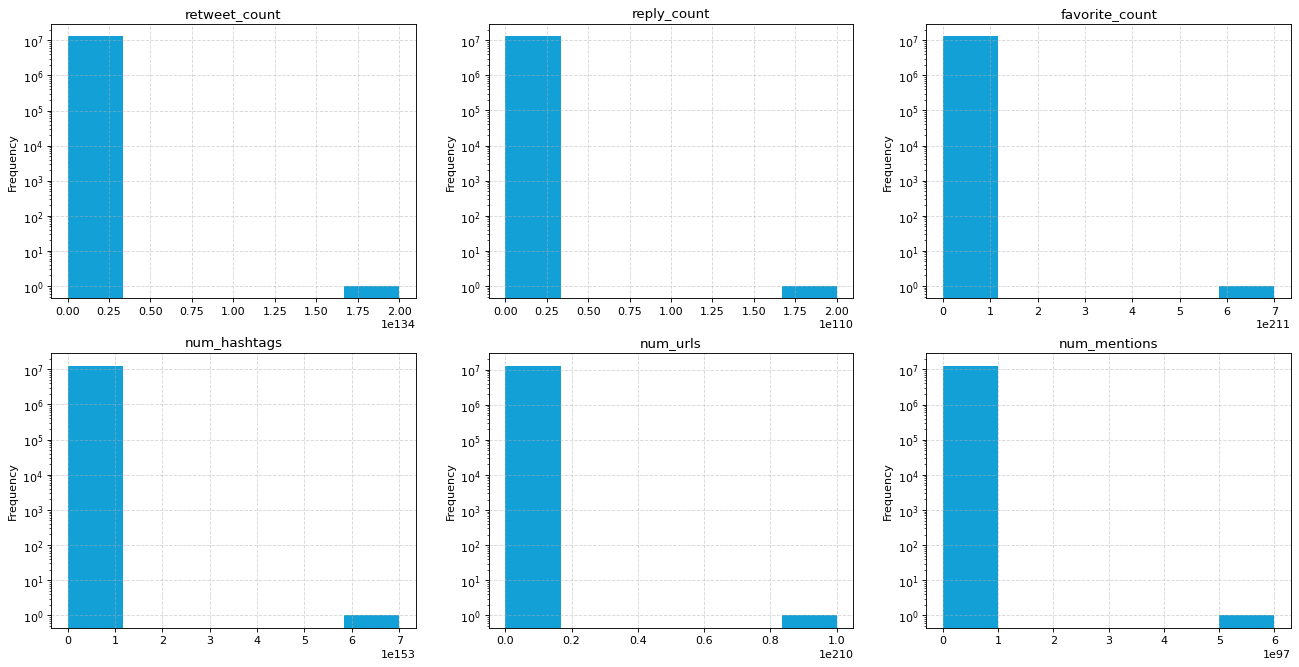

In [ ]:
def multiple_histograms(df: DataFrame, columns):
  fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, dpi=80)
  idx_col = 0

  for i in range(2):
    for j in range(3):

      col = columns[idx_col]
      idx_col +=1
      
      ax = tweets_df[col].plot.hist(bins=6, logy=True,
                                    align='mid',title=col,
                                    grid=True,figsize=(20,10),
                                    ax = axs[i, j], color=color)

      ax.grid(axis='both', alpha=0.5, linestyle='--')
   
      
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags",  "num_urls", "num_mentions"] 

multiple_histograms(tweets_df, columns=columns)

As we can see from the scale the number differ in width till a scale of 10^210, but for only few tweets. This can be read as a clear mark of rows outside the normal distribution.

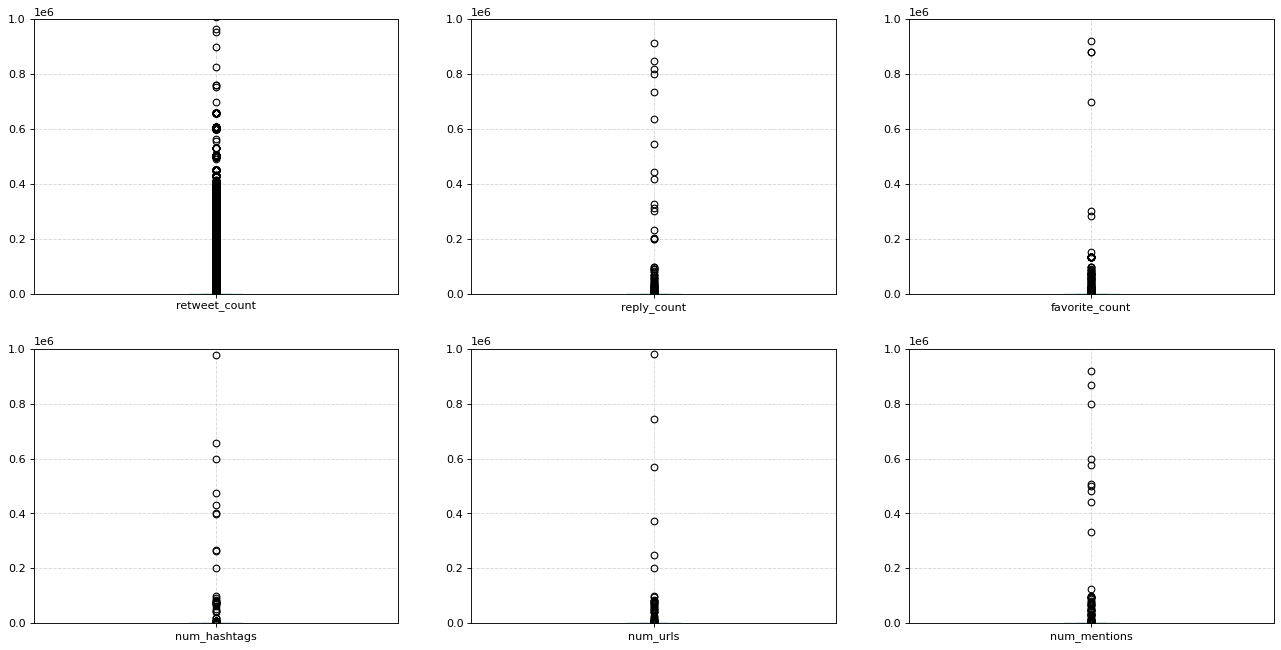

In [ ]:
def multiple_boxplots(df: DataFrame, columns):
  fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, dpi=80)
  fig.set_size_inches(20, 10)
  idx_col = 0

  for i in range(2):
    for j in range(3):

      col = columns[idx_col]
      idx_col +=1

      ax = tweets_df[col].plot.box(showmeans=True, 
                              grid=True, ax = axs[i, j])
      ax.set_ylim(-10, 1000000)


      ax.grid(axis='both', alpha=0.5, linestyle='--')
   
      
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags",  "num_urls", "num_mentions"] 

multiple_boxplots(tweets_df, columns=columns)

As we can see from the boxplots above there are many values collapsed in dense areas, than there are very high values that will be dealt with, mantaining the significative informations, in such a way that we can have the focus in the right spots.

**Distribution of created_at**

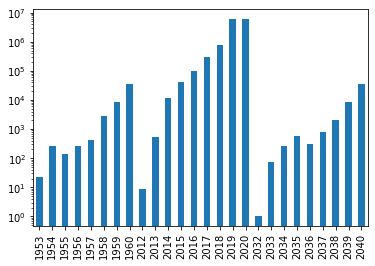

In [ ]:
years = tweets_df['created_at'].dt.year
years.value_counts().sort_index().plot(kind="bar", logy=True)

As we can see from the plot, there are multiple non sense dates of tweets since there are dates that correspond to tweets when twitter had not yet been created and dates in the future.

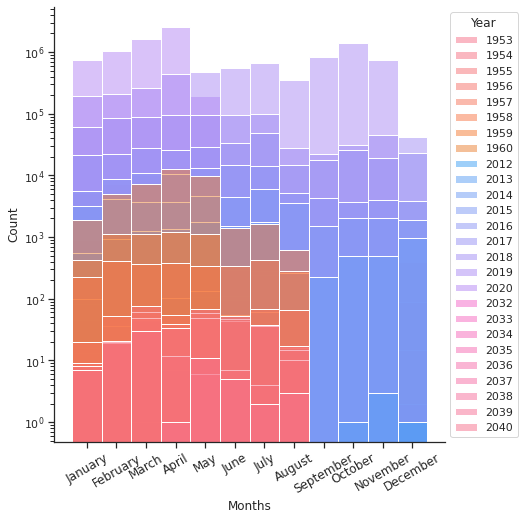

In [ ]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 8))
sns.despine(f)

# Create the histogram setting the column to be represented and the one to overlap
g = sns.histplot(
    tweets_df,
    x=tweets_df['created_at'].dt.month, hue=tweets_df['created_at'].dt.year,
    multiple='layer',
    log_scale=[False, True],
    discrete=True,
    palette='husl'
)

# Tweak the visual presentation
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xlabel('Months')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Year')
ax.set_xticklabels([month for month in calendar.month_name[1:]],
                    fontdict={'horizontalalignment': 'center', 'fontsize': 12, 'rotation': 30})
plt.show()

del g, ax

Here we can see all the years tweets distribution over same months

In [ ]:
today = pd.to_datetime("today")     # we set today since there are no tweets later than 2020 with meaningful
twitter_birth = pd.to_datetime("2006-03-21")

mask_datesOK = (tweets_df['created_at'] < today) & (tweets_df['created_at'] > twitter_birth)  
  
print("Number of tweets with a not coherent date: ", len(tweets_df[~mask_datesOK]))

Number of tweets with a not coherent date:  97605


**Distribution of lenght of tweets**


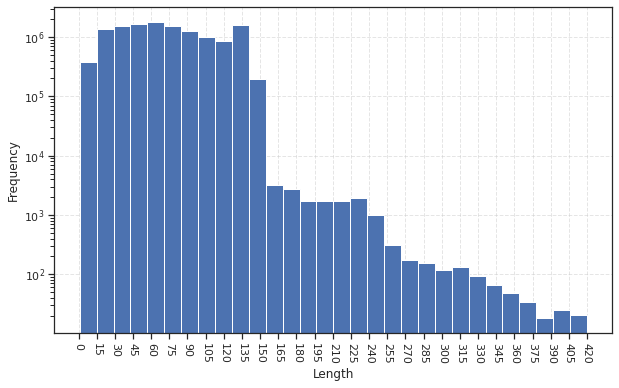

In [ ]:
ax = tweets_df['text'].str.len().plot.hist(bins=30, logy=True, 
                                           align='mid',
                                           figsize=(10,6), grid=True)
ax.set_xlabel("Length")

ax.grid(axis='both', alpha=0.5, linestyle='--')
xticks = np.arange(0, 430, 15)
ax.set_xticks(xticks)
ax.tick_params(axis='x', labelrotation=-90)
plt.show()
del ax

### Users dataset

**Distribution of created_at**

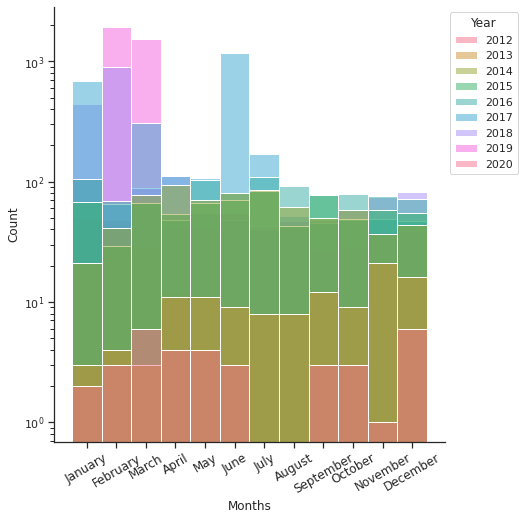

In [ ]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 8))
sns.despine(f)


# Create the histogram setting the column to be represented and the one to overlap
g = sns.histplot(
    tweets_df,
    x=users_df['created_at'].dt.month, hue=users_df['created_at'].dt.year,
    multiple='layer',
    log_scale=[False, True],
    discrete=True,
    palette='husl'
)

# Tweak the visual presentation
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xlabel('Months')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Year')
ax.set_xticklabels([month for month in calendar.month_name[1:]],
                    fontdict={'horizontalalignment': 'center', 'fontsize': 12, 'rotation': 30})
plt.show()

del g, ax

**Distribution of statuses count**

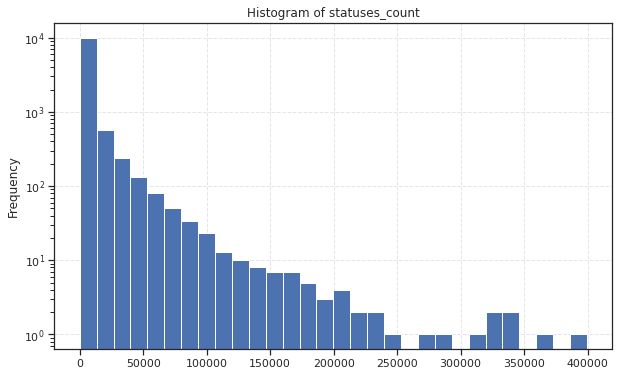

In [ ]:
ax = users_df['statuses_count'].plot.hist(bins=30, logy=True, 
                                           align='mid',title="Histogram of statuses_count",
                                           figsize=(10,6), grid=True)


ax.grid(axis='both', alpha=0.5, linestyle='--')

del ax

## Visualizing data distributions by differentiating bots and non-bots.


### Languages of actual users and bot

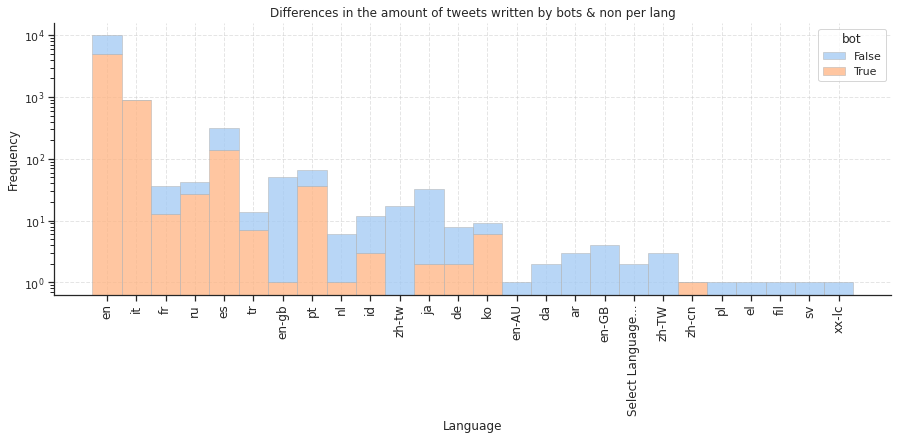

In [ ]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)

sns.histplot(
    users_df,
    x='lang', hue='bot',
    multiple="stack",
    palette=sns.color_palette("pastel",2),
    edgecolor=".7",
    log_scale = [False, True],
    linewidth=.5,
    stat='count',
).set(title='Differences in the amount of tweets written by bots & non per lang')
ax.set_ylabel("Frequency")
ax.set_xlabel("Language")
ax.grid(axis='both', alpha=0.5, linestyle='--')
ax.set_xticklabels([lang for lang in users_df['lang'].unique()],
                    fontdict={'horizontalalignment': 'center', 'fontsize': 12, 'rotation': 90})
plt.show()

del f, ax

### Percentage of the number of user: Bot vs No-Bot

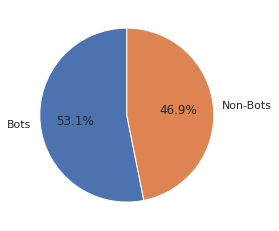

In [ ]:
bots = users_df[users_df['bot'] == 1]
non_bots = users_df[users_df['bot'] == 0]
labels = 'Bots', 'Non-Bots'
sizes = [len(bots), len(non_bots)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

### Percentage of the number of tweet :  Bot vs No-Bot

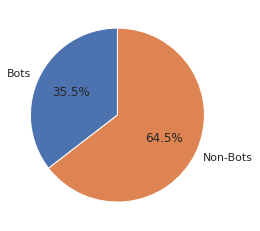

In [ ]:
bots = users_df[users_df['bot'] == 1]
non_bots = users_df[users_df['bot'] == 0]

bots_ids = bots['id'].to_list()
tweets_of_bots = tweets_df[tweets_df['user_id'].isin(bots_ids)]

non_bots_ids = non_bots['id'].to_list()
tweets_of_non_bots = tweets_df[tweets_df['user_id'].isin(non_bots_ids)]

labels = 'Bots', 'Non-Bots'
sizes = [len(tweets_of_bots), len(tweets_of_non_bots)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

### How long are the tweets written by the bots & non-bots?

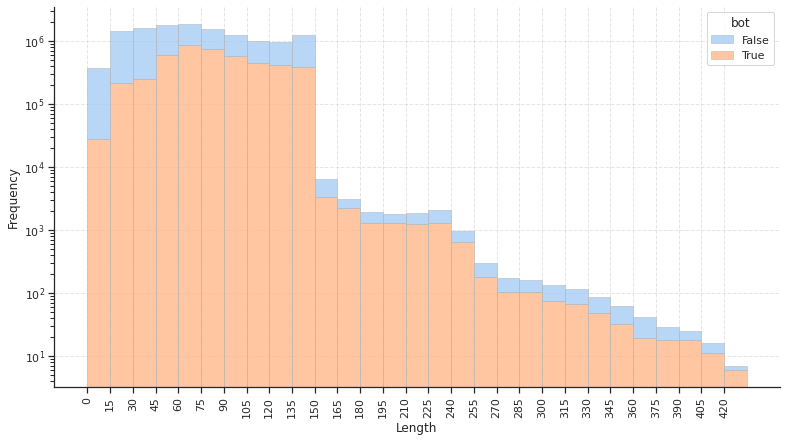

In [ ]:
bot_mask = users_df['bot'] == True
tweets_by_bot = tweets_df
tweets_by_bot['bot'] = tweets_df['user_id'].isin(users_df[bot_mask]['id'])

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(13, 7))
sns.despine(f)

sns.histplot(
    tweets_by_bot,
    x=tweets_by_bot['text'].str.len(), hue='bot',
    multiple="stack",
    palette=sns.color_palette("pastel",2),
    edgecolor=".7",
    log_scale = [False, True],
    linewidth=.5,
    stat='count',
    binwidth=15,
    binrange=[0, 430],
)
ax.set_ylabel("Frequency")
ax.set_xlabel("Length")
xticks = np.arange(0, 430, 15)
ax.set_xticks(xticks)
ax.grid(axis='both', alpha=0.5, linestyle='--')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

del f, ax

### When were the bots created (years)?

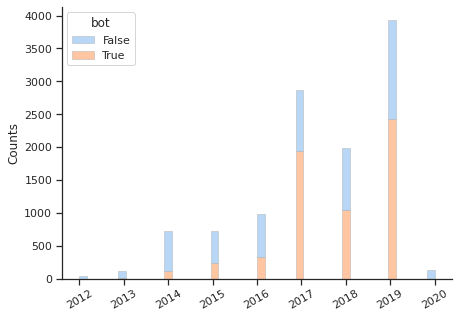

In [ ]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    users_df,
    x=users_df['created_at'].dt.year, hue='bot',
    multiple="stack",
    palette=sns.color_palette("pastel",2),
    edgecolor=".7",
    log_scale = [False, False],
    linewidth=.5,
    stat='count',
)
ax.set_ylabel("Counts")
ax.set_xlabel("")
ax.grid(axis='both', alpha=0.5, linestyle='')
ax.tick_params(axis='x', labelrotation=30)
plt.show()

del f, ax

### Calendar Heatmaps

Here there are plots showing how much sparse the data are in the years, as we can see most of the days have few tweets compared with the spikes in late 2019 and early 2020.

Calendar heatmap of tweets wrote by bots

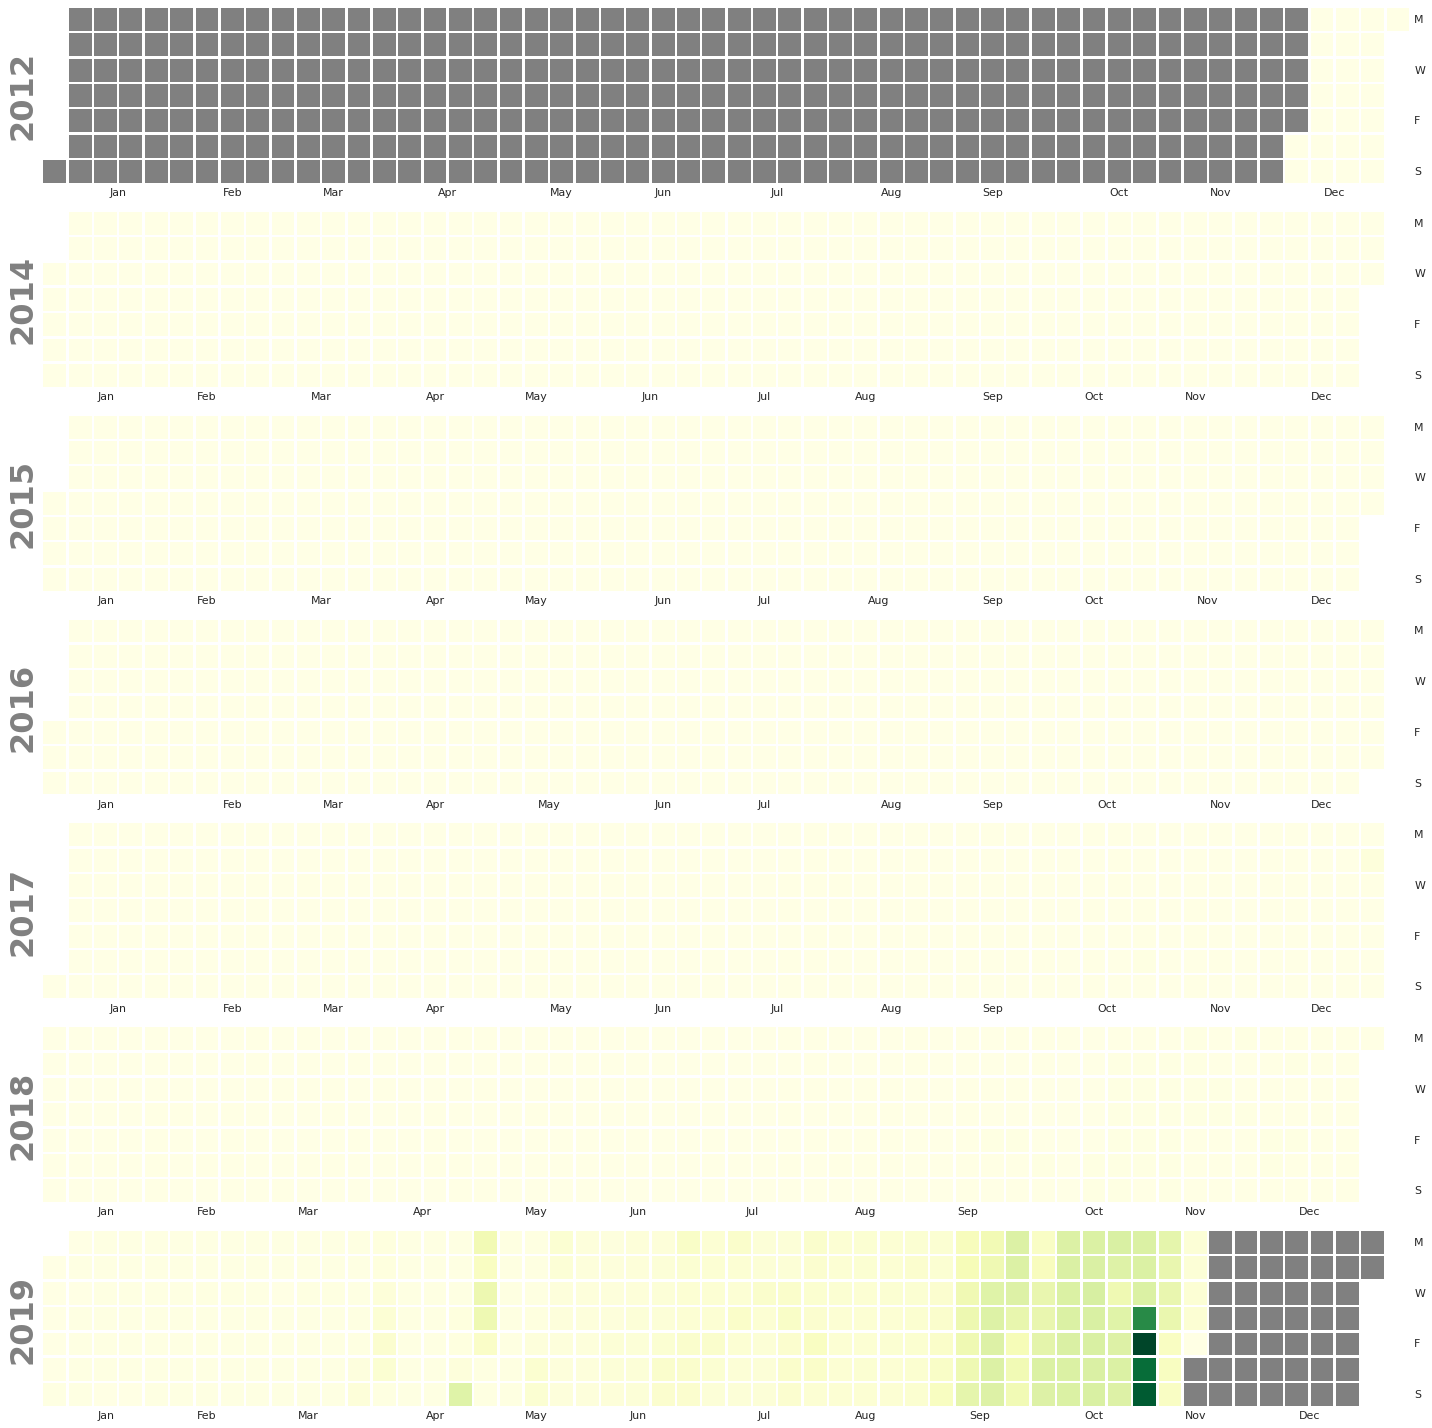

In [ ]:
bots = users_df[users_df['bot'] == True]
bots_id = bots['id'].to_list()
bots_tweets_df = tweets_df[tweets_df['user_id'].isin(bots_id)]
events = bots_tweets_df['created_at'].value_counts()

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', 
                    linewidth=1.5,
                    fig_kws=dict(figsize=(30, 20)))
plt.show()

Calendar heatmap of tweets wrote by non-bots


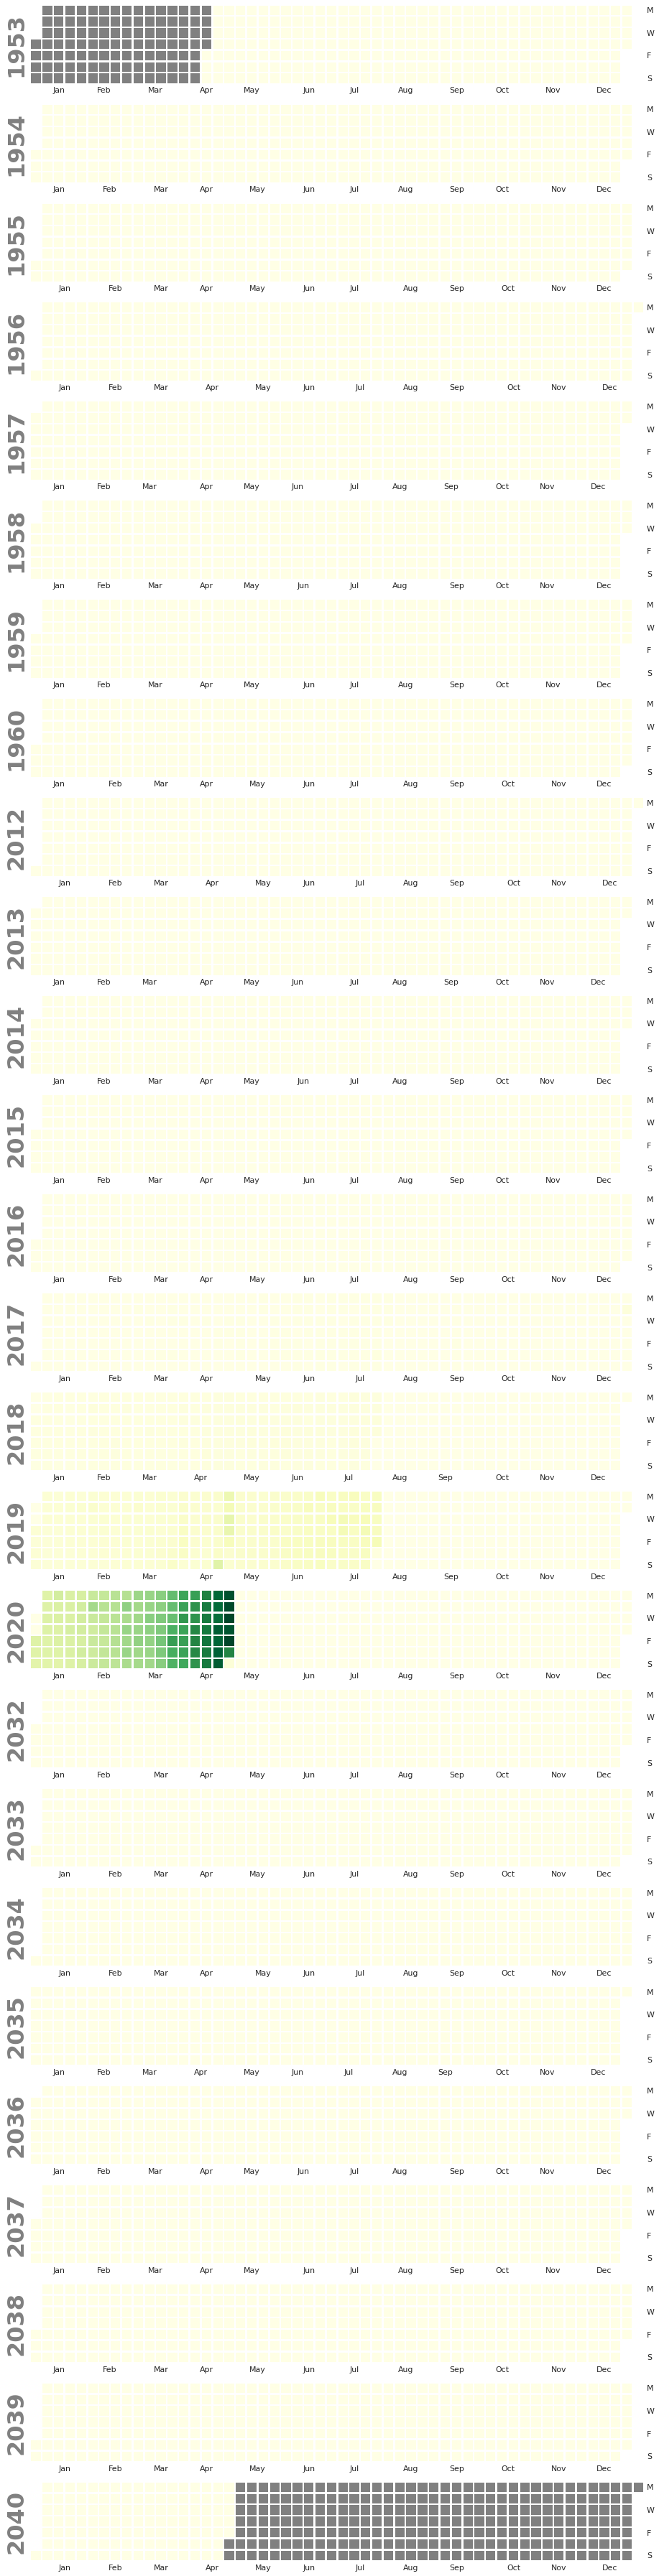

In [ ]:
bots = users_df[users_df['bot'] == False]
bots_id = bots['id'].to_list()
bots_tweets_df = tweets_df[tweets_df['user_id'].isin(bots_id)]
events = bots_tweets_df['created_at'].value_counts()

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', 
                    linewidth=1.5,
                    fig_kws=dict(figsize=(30, 50)))
plt.show()

Calendar heatmap of creation of bots


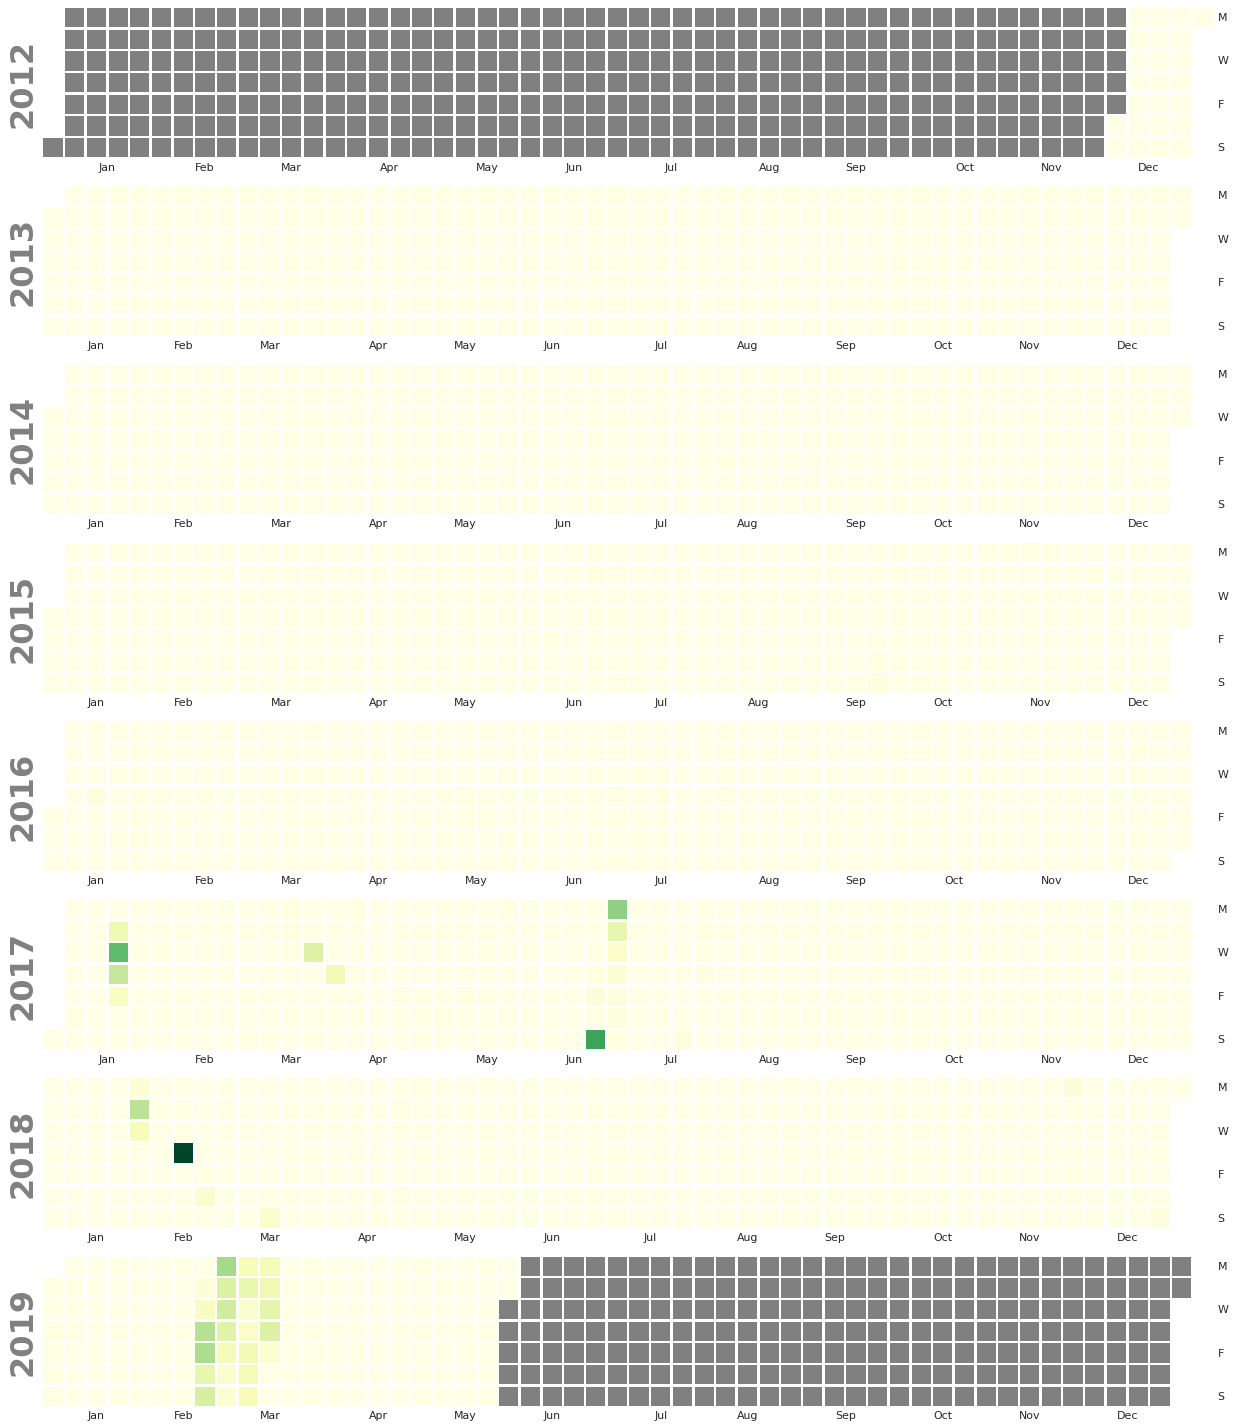

In [ ]:
bots = users_df[users_df['bot'] == True]
events = bots['created_at'].value_counts()

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', 
                    linewidth=1.5, 
                    fig_kws=dict(figsize=(30, 20)))
plt.show()

Calendar heatmap of creation of non-bots


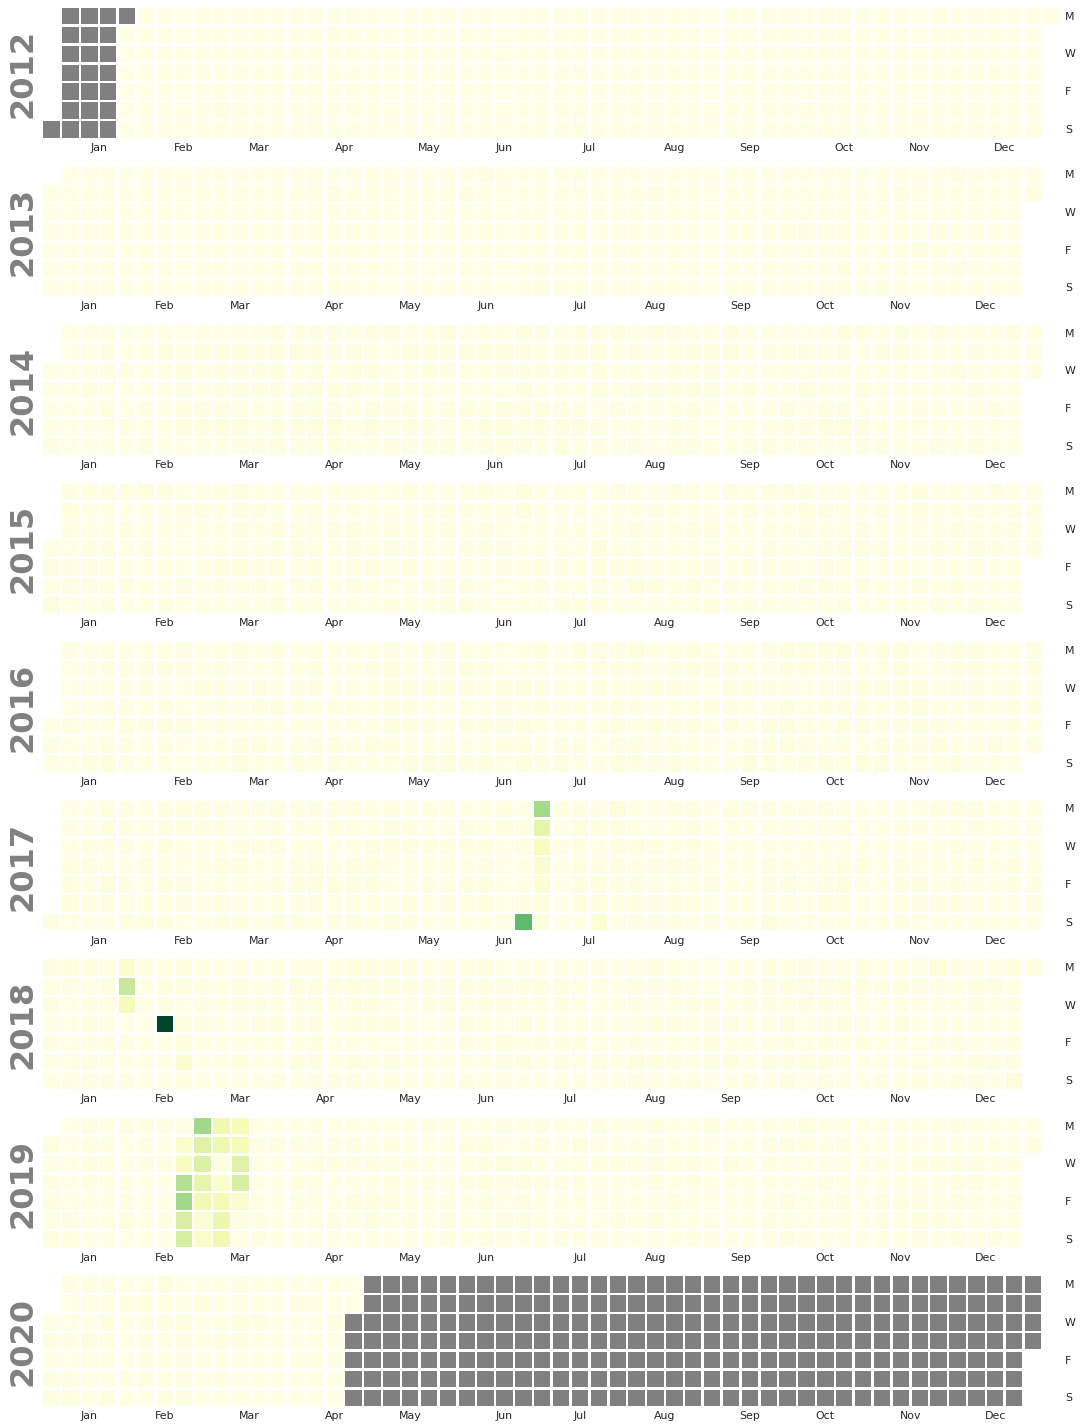

In [ ]:
non_bots = users_df[users_df['bot'] == False]
events = non_bots['created_at'].value_counts()

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', 
                    linewidth=1.5,
                    fig_kws=dict(figsize=(30, 20)))
plt.show()